In [34]:
import numpy as np

day = "Thursday"

#occupancies = np.loadtxt("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata", delimiter=",")

In [35]:
def read_matlab_float(strin):
    strin = strin.strip()
    tokens = strin.split("e")
    sign_ = tokens[1][0]
    if sign_ == "-":
        sign = -1.0
    else:
        sign = 1.0
    p = float(tokens[1][1:].strip())
    mant = float(tokens[0])
    return( mant * np.power(10.0, (sign*p)) )

def read_matlab_txt_array(filepath, delimiter=","):
    with open(filepath) as f:
        rows_ = f.readlines()
        rows = [ row.strip().split(delimiter) for row in rows_ ]
        output = np.zeros( (len(rows), len(rows[0])) )
        for i in range(len(rows)):
            for j in range(len(rows[i])):
                output[i,j] = read_matlab_float(rows[i][j])
    return(output)
        
    
test = "1.122949e-13"
read_matlab_float(test)

1.122949e-13

In [36]:
import numpy as np

loads = read_matlab_txt_array("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/" + day + "_blockface_Average_Loads_Matlab.csv")
rates = np.loadtxt("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/2016_local_uniformity_fixservice/" + day + "_blockface_True_Arrivals_By_Block.csv", delimiter=",")


In [37]:
loads.shape

(256, 12)

In [38]:
import sys
import os
sys.path.append("/home/chase/projects/net-queue/src/python/qnet")
from qnet import parameters

global_params = parameters()
global_params.read("/home/chase/projects/net-queue/data/simulation/belltownsims/sims/Monday/12/ARRIVAL_RATE_hour_12_params.txt")
global_params.VERBOSE = False

In [39]:
import copy
import os

exppath = "/home/chase/projects/net-queue/data/simulation/block_closure/sims/" + day + "/"
if not os.path.exists(exppath):
    os.mkdir(exppath)

mcfile = open(exppath + "/runMC.sh", 'w')

for j in range(rates.shape[1]):
    if not os.path.exists(exppath + "/hour_" + str(j)):
        os.mkdir(exppath + "/hour_" + str(j))
    for i in range(20):
        top = np.argpartition(loads[:,j] , -i)
        top = top[-i:]
        new_params = parameters()
        new_params.read("/home/chase/projects/net-queue/data/simulation/belltownsims/sims/Monday/12/ARRIVAL_RATE_hour_12_params.txt")
        new_params.EXOGENOUS_INTERARRIVAL = np.diag(rates[:,j])
        new_params.VERBOSE = False
        if i != 0:
            for t in top:
                new_params.EXOGENOUS_INTERARRIVAL[t,t] = 0.0
                new_params.NUM_SPOTS[t,t] = 0

        if not os.path.exists(exppath + "/hour_" + str(j) + "/closure_" + str(i)):
            os.mkdir(exppath + "/hour_" + str(j) + "/closure_" + str(i))

        new_params.write(exppath + "/hour_" + str(j) + "/closure_" + str(i), "closure_" + str(i))

        qnetpath = "/home/chase/projects/net-queue/src/python/qnet/nbus_batch.py"
        outpath = exppath + "hour_" + str(j) + "/closure_" + str(i)
        paramfilepath = outpath + "/closure_" + str(i) + "_PARAMS.txt"

        for i in range(5):
            mcfile.write("python " + qnetpath + " " + paramfilepath + " " + outpath + "\n")

mcfile.close()

In [20]:
mcfile.close()

NameError: name 'new_params' is not defined

In [7]:
import numpy as np
import os

output = {}
arrival_output = {}

In [30]:
simdir = "/home/chase/projects/net-queue/data/simulation/block_closure/sims"
outdirs = os.listdir(simdir)
outdirs.remove("runMC.sh")
for sim in outdirs:
    num = int(sim.split("_")[1])
    arrs = []
    for f in os.listdir(simdir + "/" + sim):
        if f[0:4] == "traf":
            traff = np.loadtxt(simdir + "/" + sim + "/" + f, delimiter=",")
            for i in range(num):
                i += 1
                closed = top[-i:]
                for block in closed:
                    traff[block,:] = 0.0
            arrs.append(traff)
            
        if f == sim + "_EXOGENOUS_INTERARRIVAL.txt":
            arrival = np.loadtxt(simdir + "/" + sim + "/" + f, delimiter=",")
            arrival_output[num] = sum(sum(arrival))
            
    total = np.zeros(arrs[0].shape)
    for arr in arrs:
        total += arr
    avg = 1.0/(len(arrs)) * total
    
    output[num] = np.sum(avg)
            
    

In [28]:
arrs[0].shape

(256, 256)

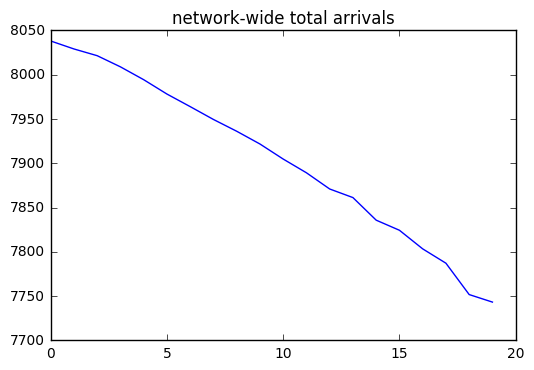

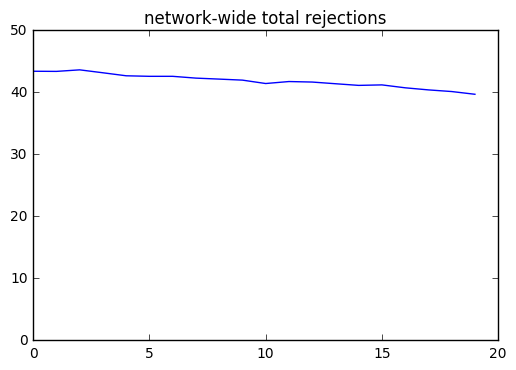

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

closures = sorted(output.keys())

vals = [ arrival_output[i] for i in closures ]

plt.plot(closures, vals)
plt.title("network-wide total arrivals")
plt.show()

vals = [ output[i] for i in closures ]

plt.plot(closures, vals)
plt.ylim([0,50])
plt.title("network-wide total rejections")
plt.show()

In [31]:
#using matlab output data
ratepath = "/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/2016_local_uniformity_fixservice/"
occuppath = "/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/"

weekthree = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]

ratefiles = os.listdir(ratepath)
occupfiles = os.listdir(occuppath)

occupmats = {}
rejmats = {}
arrmats = {}
for f in occupfiles:
    if f[0:3] in weekthree:
        occupmats[f[0:3]] = read_matlab_txt_array(occuppath + "/" + f)

for f in ratefiles:
    tokens = f.split("_")
    if tokens[2] == "Rejections":
        rejmats[tokens[0][0:3]] = 60.0/np.loadtxt(ratepath + "/" + f, delimiter=",")
    if tokens[2] == "True":
        arrmats[tokens[0][0:3]] = 60.0/np.loadtxt(ratepath + "/" + f, delimiter=",")
    
closure_data = {}
for day in weekthree:
    closure_data[day] = {}
    for hour in range(10):
        closure_data[day][hour] = {}
        closure_data[day][hour]["arr"] = []
        closure_data[day][hour]["rej"] = []
        for i in range(20):
            loads = occupmats[day][:,hour]
            top = np.argpartition(loads , -i)
            top = top[-i:]
            total_rej_rate = 0
            total_arr_rate = 0
            for j in range(len(loads)):
                if j not in top:
                    total_rej_rate += rejmats[day][j,hour]
                    total_arr_rate += arrmats[day][j,hour]
            closure_data[day][hour]["arr"].append(total_arr_rate)
            closure_data[day][hour]["rej"].append(total_rej_rate)

In [32]:
day="Mon"

for hour in range(10):
    print(closure_data[day][hour]["rej"][1])
    
print("==")

for hour in range(10):
    print(closure_data[day][hour]["arr"][1])

0.347573977048
3.64210663872
79.1566359856
95.0191368783
117.470488542
116.673616907
105.587278097
22.5658217085
20.9518711271
31.2371746947
==
114.266678062
275.563046002
413.101362941
507.985770799
573.760419161
568.050502642
528.563185957
464.198277343
429.143943963
427.883540984


In [25]:
supply = np.loadtxt("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/belltown-supply-array.txt", delimiter=",")
np.sum(np.diag(supply))

1958.0

In [28]:
eff = np.loadtxt("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/2016_local_uniformity_fixservice/Friday_blockface_Effective_Arrivals_By_Block.csv", delimiter=",")
true = np.loadtxt("/home/chase/projects/net-queue/data/simulation/belltownsims/belltowndata/2016_local_uniformity_fixservice/Friday_blockface_True_Arrivals_By_Block.csv", delimiter=",")

In [30]:
true

array([[ 500.  ,   20.24,   12.18, ...,  500.  ,  500.  ,  500.  ],
       [ 500.  ,   26.52,   26.52, ...,  500.  ,  500.  ,  500.  ],
       [  66.08,   26.24,   17.36, ...,   14.04,   13.86,   12.8 ],
       ..., 
       [ 118.94,   41.76,   17.58, ...,   10.06,   12.46,   14.82],
       [ 208.9 ,   67.38,   34.82, ...,   24.5 ,   31.66,   30.86],
       [ 147.46,   46.  ,   27.64, ...,   37.54,   52.4 ,   52.66]])